# Reddit Stock Analysis
The aim of this notebook is to process and analyse data from the popular subreddit "wallstreetbets" in a way so that it can be used to support certain trading strategies. 

By analysing the sentiment and number of comments for each post for each stock and then aggregating this to a score for each day we try to find future trends in the stock market in order to create a strategy to outperform the general stock market.

### 0. Import libraries

In [ ]:
import pandas as pd
import dask.dataframe as dd
import mapply # to speed up processing, use mapply() instead of apply() for tasks that can run in parallel (i.e., tasks that have no side effects)
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
import simfin as sf
import requests
import plotly.express as px
from datetime import timedelta
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
mapply.init(n_workers=-1, progressbar=False)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 1. Reddit data import

Import the Reddit data (i.e., posts of the r/wallstreetbets subreddit) from the `data_wsb` folder as a pandas dataframe:

In [ ]:


df_reddit_posts = dd.read_csv('data_wsb/wsb_posts__*.csv', dtype={'title': 'string', 'body': 'string'}).compute()\
    .drop_duplicates(subset=['id'])\
    .rename(columns={'num_comments': 'comms_num'})\
    [['timestamp', 'score', 'comms_num', 'title', 'body']]\
    .sort_values(by=['timestamp'])\
    .reset_index(drop=True)

df_reddit_posts

,timestamp,score,comms_num,title,body
0,2020-12-01 00:00:14,1,0,Onto something new,<NA>
1,2020-12-01 00:00:39,1,11,How to get into stocks as a poor/broke person.,I have about $10 disposable not going towards ...
2,2020-12-01 00:01:13,1,5,Cannabis vote,"Folks, what’s the best cannabis stocks for the..."
3,2020-12-01 00:01:49,1,127,WSBVoteBot Log for Dec 01 2020,Every time a new submission is posted to walls...
4,2020-12-01 00:02:04,1,0,I lost hope,<NA>
...,...,...,...,...,...
984123,2021-05-01 23:55:13,1,0,Marathon Digital Good Play?,[removed]
984124,2021-05-01 23:55:30,1,1,LETS FLY TO MOON 🚀,<NA>
984125,2021-05-01 23:56:06,1,2,Just spent all my money on a Hawaiian Vacation...,<NA>
984126,2021-05-01 23:57:15,1,0,Scammers allowed here?,[removed]


## 2. Analyze dominantly occurring words

In [ ]:
def show_wordcloud(data, title=""):
    text = " ".join(t for t in data.dropna())
    stopwords = set(STOPWORDS)
    stopwords.update(["t", "co", "https", "amp", "U", "fuck", "fucking", "removed", "deleted"])
    wordcloud = WordCloud(stopwords=stopwords, scale=4, max_font_size=50, max_words=500,background_color="black").generate(text)
    fig = plt.figure(1, figsize=(16,16))
    plt.axis('off')
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

In [ ]:
#set dynamic date for the last 14 days
df_reddit_posts['timestamp'] = pd.to_datetime(df_reddit_posts['timestamp'], format = '%Y-%m-%d').dt.normalize()
from datetime import timedelta
last_day = df_reddit_posts.iloc[0,0]
previous_days = timedelta(days=31)
timespan = last_day-previous_days

In [ ]:
df_reddit_posts_filtered = df_reddit_posts.loc[(df_reddit_posts['timestamp'] >= timespan)
                            & (df_reddit_posts['timestamp'] <= last_day)]

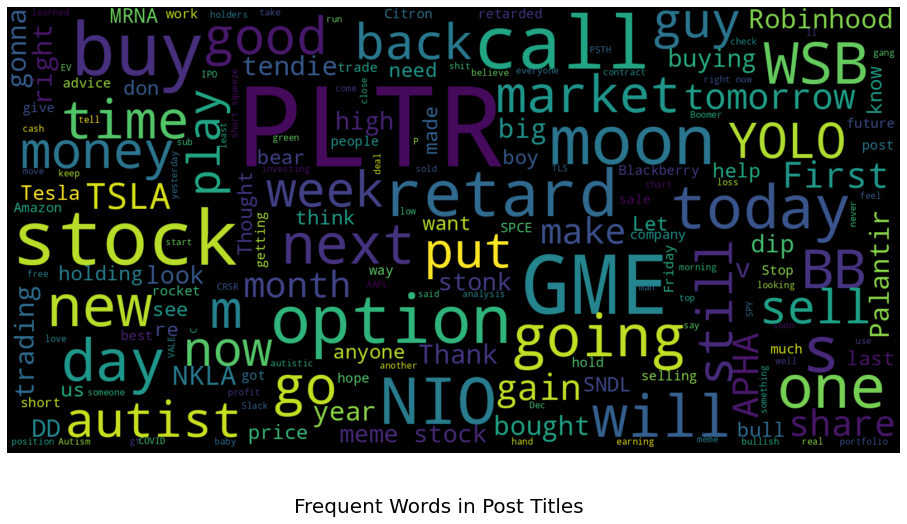

In [ ]:
show_wordcloud(df_reddit_posts_filtered['title'], title = 'Frequent Words in Post Titles')

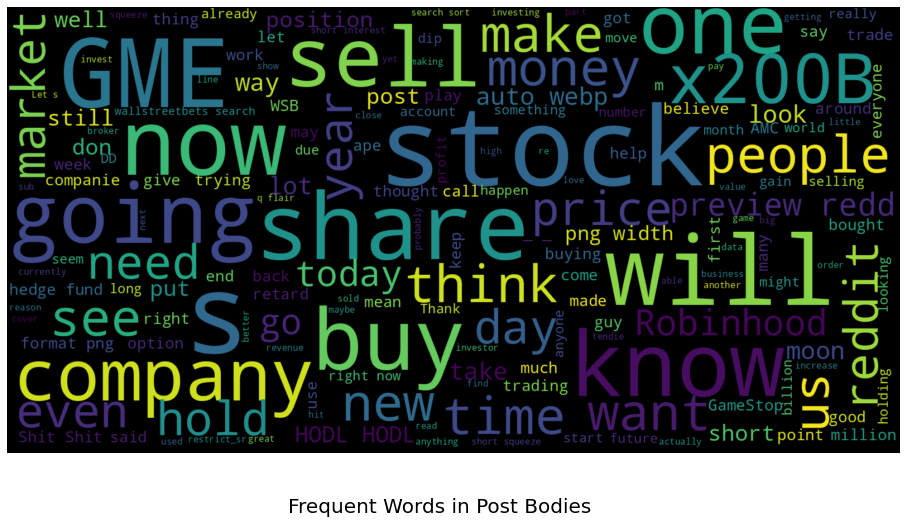

In [ ]:
show_wordcloud(df_reddit_posts['body'], title = 'Frequent Words in Post Bodies')

## 3. Label posts by which stocks they mention

One of the main goals of the analysis is to calculate the interest in and sentiment regarding specific stocks.
Thus, it is necessary to detect which stock(s) each post refers to.

### 3.1. Tokenization

In order to label each post by which stocks it mentions, the post's title and body are first tokenized, i.e.:

1. The text is converted to all lower-case letters
2. All special characters are filtered out

In [ ]:
def tokenize(text):
    text = text.lower()
    text = re.sub("\W+", " ", text)
    return " ".join(text.split())

df_reddit_posts['tokens'] = df_reddit_posts['title'].fillna('') + (' ' + df_reddit_posts['body']).fillna('')
df_reddit_posts['tokens'] = df_reddit_posts['tokens'].apply(tokenize)
df_reddit_posts.head(5)

,timestamp,score,comms_num,title,body,tokens
0,2020-12-01,1,0,Onto something new,<NA>,onto something new
1,2020-12-01,1,11,How to get into stocks as a poor/broke person.,I have about $10 disposable not going towards ...,how to get into stocks as a poor broke person ...
2,2020-12-01,1,5,Cannabis vote,"Folks, what’s the best cannabis stocks for the...",cannabis vote folks what s the best cannabis s...
3,2020-12-01,1,127,WSBVoteBot Log for Dec 01 2020,Every time a new submission is posted to walls...,wsbvotebot log for dec 01 2020 every time a ne...
4,2020-12-01,1,0,I lost hope,<NA>,i lost hope


## 4.&nbsp;Analysis&nbsp;of&nbsp;most&nbsp;mentioned&nbsp;Stock&nbsp;Tickers&nbsp;and&nbsp;Company&nbsp;Names

The goal of this analysis is to filter the most mentioned Ticker Symbols in the Reddit Comments and to provide a list and the development of number of posts for this Stock Tickers. 

### 4.1 Prepare Ticker Symbols

The free Simfin API provides a list of Ticker Symbols and Company Names of all listed Companies in America

In [ ]:
#use Simfin API to get stock ticker and company names
# free API key to download data
sf.set_api_key('free')

# local repository for storage of data
# a new one will be created
sf.set_data_dir('~/simfin_data/')

# data download into a pandas dataframe
df_us = sf.load_companies(market='us')

#dataframe preprocessing
df_us = df_us.reset_index()
df_us_companies = df_us[["Ticker","Company Name"]]
df_us_companies['Ticker'] =  df_us_companies['Ticker'].astype(str)
df_us_companies['Company Name'] =  df_us_companies['Company Name'].astype(str)
df_us_companies.head()

Dataset "us-companies" on disk (0 days old).
- Loading from disk ... Done!
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Ticker,Company Name
0,A,AGILENT TECHNOLOGIES INC
1,AA,Alcoa Corp
2,AAC,"AAC Holdings, Inc."
3,AAL,American Airlines Group Inc.
4,AAMC,Altisource Asset Management Corp


The Tickers and Company Names get cleaned and prepared 

In [ ]:
#prepare Company Name and remove abbreviations from Company Name
abbreviations = [" INC", " Inc.", " Inc", " Corp", " Corp.", " Corporation", ",","."," Ltd."," Ltd","LTD","GROUP","CORP","CO"," & CO"]
for ii, name in enumerate(df_us_companies['Company Name']):
    for a in abbreviations:
        df_us_companies['Company Name'][ii] = df_us_companies['Company Name'][ii].replace(a,'') 

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


The worldlist provides a list with all english words from the nltk library. The list can be load from the csv file and gets prepared for the next steps (all word longer than 5 spaces gets removed).

In [ ]:
#import wordlist with data from nltk package to remove words in Ticker
df_wordlist = pd.read_csv('wordlist.csv')
df_wordlist['words'] = df_wordlist['words'].astype(str)

#delete long words with length greater than 5
df_wordlist.drop(df_wordlist[df_wordlist['words'].map(len) > 5].index, inplace = True)
df_wordlist.head()

,words
0,A
1,a
2,aa
3,aal
4,aalii


All Ticker Symbol which are included in the wordlist will be replaced with the Company Names as some Tickers are more often used as words as Ticker e.g. 'a','all','chart',... and some words will be replaced manually with the word_list_manual, which can be updated. The Ticker 'TIME' gets removed from the Company List as the Ticker and Company Name is 'Time' and it is most likely that time is used as word instead of a Ticker Symbole.

In [ ]:
#Create list from Dataframes and search for words in tickers
#df_wordlist #Dictionary
#df_us_companies #Ticker
wordlist_list = df_wordlist['words'].values.tolist()
#manual word list to remove tickers not in the wordlist dictionary
word_list_manual = ['has', 'time', 'www', 'apps', 'info', 'cars', 'll', 'dd', 'rh']
companies_list = df_us_companies['Ticker'].values.tolist()
index_list = []

#Delete Ticker TIME, because Ticker and Company name is the same
ticker_index = df_us_companies[df_us_companies['Ticker']=='TIME'].index
df_us_companies.drop(ticker_index, inplace= True)

for ii, ticker in enumerate(companies_list):
    if ticker.lower() in wordlist_list or ticker.lower() in word_list_manual:
        index_list.append(ii) 

#replace founded words in Ticker with Company Name
df_us_companies_updated = df_us_companies
for index in index_list:
    df_us_companies_updated.at[index,'Ticker'] = df_us_companies_updated.iloc[index,1]

df_us_companies_updated

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:3281: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[index, col] = value


,Ticker,Company Name
0,AGILENT TECHNOLOGIES,AGILENT TECHNOLOGIES
1,Alcoa,Alcoa
2,AAC,AAC Holdings
3,American Airlines Group,American Airlines Group
4,AAMC,Altisource Asset Management
...,...,...
2697,ZUO,ZUORA
2698,ZVO,Zovio
2699,ZYNE,Zynerba Pharmaceuticals
2700,ZYXI,ZYNEX


The&nbsp;Company&nbsp;Dataframe&nbsp;will&nbsp;be&nbsp;converted&nbsp;into&nbsp;a&nbsp;dictionary&nbsp;and&nbsp;the&nbsp;als&nbsp;entries&nbsp;are&nbsp;converted&nbsp;to&nbsp;lower&nbsp;case.

In [ ]:
#pandas to dict and to lower case
df_us_companies_updated['Ticker'] =  df_us_companies_updated['Ticker'].astype(str)
df_us_companies_updated['Company Name'] =  df_us_companies_updated['Company Name'].astype(str)
df_us_companies_updated = df_us_companies_updated.set_index('Ticker')
ticker_symbol = df_us_companies_updated.to_dict()
ticker_symbol_synonyms = dict((k.lower(), list([v.lower()])) for k,v in ticker_symbol['Company Name'].items())
#df_reddit_posts_2 = df_reddit_posts
#df_reddit_posts_2['timestamp'] = pd.to_datetime(df_reddit_posts_2['timestamp'], format = '%Y-%m-%d').dt.normalize()
#df_reddit_posts_2
ticker_symbol_synonyms

{'agilent technologies': ['agilent technologies'],
 'alcoa': ['alcoa'],
 'aac': ['aac holdings'],
 'american airlines group': ['american airlines group'],
 'aamc': ['altisource asset management'],
 'aame': ['atlantic american '],
 'aan': ["aaron's"],
 'aaoi': ['applied optoelectronics'],
 'aaon': ['aaon'],
 'aap': ['advance auto parts'],
 'aapl': ['apple'],
 'aat': ['american assets trust'],
 'aaww': ['atlas air worldwide holdings'],
 'abax': ['abaxis'],
 'abbv': ['abbvie'],
 'abc': ['amerisourcebergen '],
 'abcb': ['ameris bancorp'],
 'abcd': ['cambium learning '],
 'abd': ['ac brands'],
 'abeo': ['abeona therapeutics'],
 'abg': ['asbury automotive '],
 'abio': ['arca biopharma'],
 'abm': ['abm industries /de/'],
 'abmc': ['american bio medica '],
 'abmd': ['abiomed'],
 'abr': ['arbor realty trust'],
 'abt': ['abbott laboratories'],
 'abtl': ['autoweb'],
 'abtx': ['allegiance bancshares'],
 'abus': ['arbutus biopharma'],
 'ac': ['associated capital group'],
 'aca': ['arcosa'],
 'acad'

In [ ]:
df_reddit_posts.head(10)

,timestamp,score,comms_num,title,body,tokens
0,2020-12-01,1,0,Onto something new,<NA>,onto something new
1,2020-12-01,1,11,How to get into stocks as a poor/broke person.,I have about $10 disposable not going towards ...,how to get into stocks as a poor broke person ...
2,2020-12-01,1,5,Cannabis vote,"Folks, what’s the best cannabis stocks for the...",cannabis vote folks what s the best cannabis s...
3,2020-12-01,1,127,WSBVoteBot Log for Dec 01 2020,Every time a new submission is posted to walls...,wsbvotebot log for dec 01 2020 every time a ne...
4,2020-12-01,1,0,I lost hope,<NA>,i lost hope
5,2020-12-01,1,0,amd all the way,[removed],amd all the way removed
6,2020-12-01,1,0,Can't top this feeling,<NA>,can t top this feeling
7,2020-12-01,1,1,Holy fuck QS insane! EV play up 80% this past ...,<NA>,holy fuck qs insane ev play up 80 this past we...
8,2020-12-01,1,20,PLTR a good buy tomorrow?,Thinking of buying 100 shares near opening tom...,pltr a good buy tomorrow thinking of buying 10...
9,2020-12-01,1,2,People just getting into $PLTR,<NA>,people just getting into pltr


### 4.2. Labelling

The final labelling of the respective stocks is determined by a dynamic search that looks through both title and body in order to identify either ticker symbols or company names

In [ ]:
# Prepare a dictionary that maps stocks (= ticker symbols + synonyms) to their respective ticker symbols:
stocks_lookup_table = { key: key for key in ticker_symbol_synonyms.keys() }
for symbol, synonyms in ticker_symbol_synonyms.items():
    for synonym in synonyms:
        stocks_lookup_table[synonym] = symbol

# Prepare a list of stocks:
stocks = set(map(lambda stock: stock, stocks_lookup_table.keys()))
stocks_space_around = set(map(lambda stock: " " + stock + " ", stocks_lookup_table.keys()))

# Extract stocks (= symbols + synonyms) mentioned in each post:
def extract_stocks(tokens):
    found_stocks = list()
    for stock in stocks_space_around:
        if stock in tokens:
            found_stocks.append(stock[1:len(stock)-1])
    return found_stocks


# df_reddit_posts = df_reddit_posts.head(1000)
df_reddit_posts['mentioned_stocks'] = df_reddit_posts['tokens'].mapply(lambda tokens: " " + tokens + " ").mapply(extract_stocks)


# Map stocks (= ticker symbols + synonyms) to their respective ticker symbols:
def lookup_symbol(stock):
    return stocks_lookup_table[stock]

def lookup_symbols(stocks):
    return list(set(map(lookup_symbol, stocks)))

df_reddit_posts['mentioned_symbols'] = df_reddit_posts['mentioned_stocks'].mapply(lookup_symbols)
df_reddit_posts

,timestamp,score,comms_num,title,body,tokens,mentioned_stocks,mentioned_symbols
0,2020-12-01,1,0,Onto something new,<NA>,onto something new,[],[]
1,2020-12-01,1,11,How to get into stocks as a poor/broke person.,I have about $10 disposable not going towards ...,how to get into stocks as a poor broke person ...,[],[]
2,2020-12-01,1,5,Cannabis vote,"Folks, what’s the best cannabis stocks for the...",cannabis vote folks what s the best cannabis s...,[],[]
3,2020-12-01,1,127,WSBVoteBot Log for Dec 01 2020,Every time a new submission is posted to walls...,wsbvotebot log for dec 01 2020 every time a ne...,[],[]
4,2020-12-01,1,0,I lost hope,<NA>,i lost hope,[],[]
...,...,...,...,...,...,...,...,...
984123,2021-05-01,1,0,Marathon Digital Good Play?,[removed],marathon digital good play removed,[],[]
984124,2021-05-01,1,1,LETS FLY TO MOON 🚀,<NA>,lets fly to moon,[],[]
984125,2021-05-01,1,2,Just spent all my money on a Hawaiian Vacation...,<NA>,just spent all my money on a hawaiian vacation...,[gme],[gme]
984126,2021-05-01,1,0,Scammers allowed here?,[removed],scammers allowed here removed,[],[]


### 4.3. Post-Processing

* **Filter irrelevant posts:** Posts that do not mention any stocks are irrelevant to the further analysis. Thus, they are removed.
* **Remove unnecessary columns:** Columns that contain intermediate results for labeling are removed.
* **Split posts:** All posts that mention more than one stock are exploded into multiple rows (one for each stock).

In [ ]:
def non_empty(_list):
    return len(_list) > 0

df_reddit_posts_exploded = df_reddit_posts\
    [df_reddit_posts['mentioned_symbols'].apply(non_empty)]\
    .reset_index(drop=True)\
    .drop(columns=['tokens', 'mentioned_stocks'])\
    .explode('mentioned_symbols')\
    .rename(columns={'mentioned_symbols': 'mentioned_symbol'})\
    .reset_index(drop=True)
    
df_reddit_posts_exploded

,timestamp,score,comms_num,title,body,mentioned_symbol
0,2020-12-01,1,0,amd all the way,[removed],amd
1,2020-12-01,1,1,Holy fuck QS insane! EV play up 80% this past ...,<NA>,qs
2,2020-12-01,1,1,Holy fuck QS insane! EV play up 80% this past ...,<NA>,ev
3,2020-12-01,1,20,PLTR a good buy tomorrow?,Thinking of buying 100 shares near opening tom...,pltr
4,2020-12-01,1,2,People just getting into $PLTR,<NA>,pltr
...,...,...,...,...,...,...
502626,2021-05-01,1,2,Just hear me out! Phillip Morris reminds me of...,How many see what is actually transpiring with...,amp
502627,2021-05-01,1,7,MRNA 3X?,I honestly think mrna's forward PE justifies a...,mrna
502628,2021-05-01,1,7,MRNA 3X?,I honestly think mrna's forward PE justifies a...,pe
502629,2021-05-01,1,2,Just spent all my money on a Hawaiian Vacation...,<NA>,gme


## 4.4 Most mentioned Stock Ticker

### 4.4.1 Analysis of the top 10 most mentioned Stock Ticker 

Show the most mentioned Ticker Symbols

In [ ]:
#show most mentiond Stocks in Reddit Comments
df_posts_count_sorted = df_reddit_posts_exploded\
            .groupby(['mentioned_symbol'])['title'].count().reset_index()\
            .rename(columns={'title': 'number_of_posts'})\
            .sort_values(by=['number_of_posts','mentioned_symbol'], ascending=False)

df_posts_count_sorted.head(20)

,mentioned_symbol,number_of_posts
711,gme,182527
108,amc,75870
506,dnow,49079
200,bb,27170
119,amp,23265
1316,rh,12361
404,cprt,9318
1568,tsla,8759
1232,pltr,7890
1583,twtr,4254


Show the most mentioned Stock Ticker per day and remove days with less than 5 comments per Ticker

In [ ]:
#show most mentioned Stocks in Reddit Comments per day
df_posts_count = df_reddit_posts_exploded\
            .groupby(['mentioned_symbol','timestamp'])['title'].count().reset_index()\
            .rename(columns={'title': 'number_of_posts'})\
            .sort_values(by=['timestamp','number_of_posts','mentioned_symbol'], ascending=False)

df_posts_count = df_posts_count\
    [df_posts_count['number_of_posts'] > 5]\
    .reset_index(drop=True)
df_posts_count

,mentioned_symbol,timestamp,number_of_posts
0,gme,2021-05-01,57
1,dnow,2021-05-01,49
2,amp,2021-05-01,36
3,mvis,2021-05-01,21
4,tsla,2021-05-01,20
...,...,...,...
4540,twtr,2020-12-01,6
4541,gm,2020-12-01,6
4542,fds,2020-12-01,6
4543,fb,2020-12-01,6


### 4.4.2 Visualization of top 10 most mentioned Stock Ticker

In [ ]:
df_posts_top = df_posts_count_sorted.iloc[:20,0].reset_index()
symbols = df_posts_top['mentioned_symbol'].unique()

df_posts_count_prepared = df_posts_count[df_posts_count['mentioned_symbol'].isin(symbols)]

df_posts_top_plot = df_posts_count_prepared\
                                .pivot_table(index='timestamp',columns='mentioned_symbol',values='number_of_posts')\
                                .fillna(0)
df_posts_top_plot = df_posts_top_plot.reset_index()
df_posts_top_plot

mentioned_symbol,timestamp,aapl,amc,amp,bb,bbby,cprt,dnow,ev,expr,...,gme,gt,mvis,pltr,rh,spce,tlry,tsla,twtr,yhoo
0,2020-12-01,30.0,0.0,145.0,61.0,0.0,17.0,185.0,28.0,0.0,...,155.0,22.0,0.0,330.0,7.0,16.0,0.0,68.0,6.0,7.0
1,2020-12-02,21.0,0.0,106.0,34.0,0.0,22.0,153.0,17.0,0.0,...,78.0,11.0,0.0,311.0,7.0,8.0,0.0,78.0,7.0,9.0
2,2020-12-03,0.0,0.0,55.0,0.0,0.0,8.0,68.0,12.0,0.0,...,32.0,6.0,0.0,130.0,0.0,0.0,0.0,53.0,0.0,0.0
3,2020-12-04,0.0,6.0,72.0,10.0,0.0,9.0,83.0,13.0,0.0,...,49.0,8.0,0.0,95.0,0.0,7.0,0.0,47.0,9.0,0.0
4,2020-12-05,9.0,0.0,30.0,0.0,0.0,8.0,39.0,11.0,0.0,...,35.0,0.0,0.0,41.0,0.0,0.0,0.0,25.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2021-04-27,19.0,96.0,111.0,11.0,0.0,17.0,137.0,11.0,0.0,...,189.0,16.0,322.0,6.0,15.0,0.0,17.0,20.0,8.0,13.0
131,2021-04-28,20.0,81.0,94.0,10.0,0.0,14.0,117.0,10.0,0.0,...,154.0,8.0,160.0,10.0,0.0,0.0,10.0,35.0,12.0,14.0
132,2021-04-29,20.0,49.0,89.0,8.0,0.0,8.0,125.0,10.0,0.0,...,111.0,0.0,130.0,7.0,7.0,0.0,0.0,26.0,14.0,21.0
133,2021-04-30,10.0,46.0,76.0,6.0,0.0,16.0,124.0,0.0,0.0,...,106.0,7.0,114.0,14.0,0.0,0.0,17.0,32.0,15.0,13.0


In [ ]:
fig = px.line(df_posts_top_plot, x='timestamp', y=df_posts_top_plot.columns,
              hover_data={"timestamp": "%Y-%m-%d"},
              title='development of number of posts per stock')

fig.show()

### 4.4.3 Analysis of the % change of the top 10 most mentioned Stock Ticker

Calculate the percentage change of number of posts per Stock Ticker

In [ ]:
feature_columns = ['number_of_posts']

df_posts_count_changes = df_posts_count\
    .join (
        df_posts_count\
            .sort_values(['mentioned_symbol','timestamp'])\
            .reset_index(drop=True)\
            .groupby('mentioned_symbol')
            [feature_columns]\
            .pct_change()\
            .add_suffix('_change')
    )\
    #.drop(columns=feature_columns)
    
df_posts_count_changes=df_posts_count_changes.sort_values(['mentioned_symbol','timestamp'])

In [ ]:
df_posts_top = df_posts_count_sorted.iloc[:20,0].reset_index()
symbols = df_posts_top['mentioned_symbol'].unique()

df_posts_change_prepared = df_posts_count_changes[df_posts_count_changes['mentioned_symbol'].isin(symbols)]

df_posts_top_changes_plot = df_posts_change_prepared\
                                .pivot_table(index='timestamp',columns='mentioned_symbol',values='number_of_posts_change')\
                                .fillna(0)
df_posts_top_changes_plot = df_posts_top_changes_plot.reset_index()
df_posts_top_changes_plot

mentioned_symbol,timestamp,aapl,amc,amp,bb,bbby,cprt,dnow,ev,expr,...,gme,gt,mvis,pltr,rh,spce,tlry,tsla,twtr,yhoo
0,2020-12-01,-0.300000,0.000000,-0.100000,-0.200000,0.0,0.444444,-0.100000,-0.142857,0.0,...,0.111111,1.833333,0.000000,0.250000,0.714286,-0.307692,0.000000,0.666667,0.833333,-0.461538
1,2020-12-02,-0.083333,0.000000,0.200000,0.000000,0.0,0.200000,0.111111,0.454545,0.0,...,-0.562500,-0.433333,0.000000,0.500000,2.391304,0.532258,0.000000,0.333333,-0.651515,-0.071429
2,2020-12-03,0.000000,0.000000,0.000000,0.000000,0.0,1.083333,0.000000,0.500000,0.0,...,-0.200000,-0.454545,0.000000,-0.380952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-12-04,0.000000,0.500000,0.400000,0.100000,0.0,-0.200000,-0.333333,0.444444,0.0,...,-0.071429,-0.125000,0.000000,0.000000,0.000000,0.428571,0.000000,-0.384615,-0.090909,0.000000
4,2020-12-05,-0.366667,0.000000,0.704545,0.000000,0.0,-0.117647,0.823529,0.384615,0.0,...,0.419355,0.000000,0.000000,1.125000,0.000000,0.000000,0.000000,-0.440000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,2021-04-27,-0.650000,0.000000,-0.333333,0.888889,0.0,0.500000,-0.437500,-0.307692,0.0,...,1.666667,0.083333,-0.400000,-0.100000,-0.230769,0.000000,0.142857,-0.083333,-0.461538,0.100000
131,2021-04-28,-0.655172,-0.538462,-0.133333,0.260870,0.0,-0.360000,-0.062500,0.916667,0.0,...,-0.360000,0.000000,-0.264706,-0.368421,0.000000,0.000000,-0.136364,1.833333,0.375000,0.086957
132,2021-04-29,0.857143,-0.181818,-0.488372,2.798077,0.0,2.851852,0.562500,1.333333,0.0,...,0.720000,0.000000,-0.058824,-0.060606,-0.250000,0.000000,0.000000,-0.277778,-0.190476,-0.125000
133,2021-04-30,-0.333333,-0.142857,0.272727,0.307692,0.0,0.161290,0.250000,0.000000,0.0,...,-0.352941,-0.533333,0.700000,-0.363636,0.000000,0.000000,-0.111111,-0.250000,-0.083333,-0.285714


### 4.4.4 Visualization of the % change of top 10 most mentioned Stock Ticker

In [ ]:

fig = px.line(df_posts_top_changes_plot, x='timestamp', y=df_posts_top_changes_plot.columns,
              hover_data={"timestamp": "%Y-%m-%d"},
              title='development of % changes of number of posts per stock')

fig.show()

## 4.5 Analysis of currently most mentioned Stocks in the reddit posts

### 4.5.1 Analysis of the most mentioned Stocks in the last few days

The goal is to provide a list with the most mentioned Stocks of the last few days that can be used as Signals for ongoing changes and trends in the Reddit forum.

In [ ]:
df_posts_count_ranked = df_posts_count.sort_values(['timestamp','number_of_posts'], ascending = False).reset_index(drop=True)
df_posts_ranked_top10 = df_posts_count_ranked.groupby(['timestamp']).head(10)

Set a time period for the analysis of the last few days. The time periode can be changed by setting the previous_days(days=...) parameter.

In [ ]:
#set dynamic date for the last 14 days
last_day = df_posts_count_ranked.iloc[0,1]
previous_days = timedelta(days=14)
timespan = last_day-previous_days

The list provides an overview of the top 10 most mentioned stocks of the last few days. New trends can be identified by changes in the ranking of the top 10 per day.

In [ ]:
#get the top 10 stocks of the last 14 days
df_posts_ranked_current = df_posts_ranked_top10.loc[(df_posts_ranked_top10['timestamp'] >= timespan)
                            & (df_posts_ranked_top10['timestamp'] <= last_day)]

df_posts_ranked_current

,mentioned_symbol,timestamp,number_of_posts
0,gme,2021-05-01,57
1,dnow,2021-05-01,49
2,amp,2021-05-01,36
3,mvis,2021-05-01,21
4,tsla,2021-05-01,20
...,...,...,...
302,twtr,2021-04-17,15
303,gt,2021-04-17,15
304,aapl,2021-04-17,13
305,rh,2021-04-17,11


### 4.5.2 Analysis of most mentioned Stocks of the last day

The goal of this analysis is a deeper look on the most mentioned stocks of the last day and the development of this stocks of the last period. 

In [ ]:
#get the top 10 stocks of the last day and their development of the last 14 days
df_posts_last_ticker = df_posts_ranked_top10.loc[(df_posts_ranked_top10['timestamp'] == last_day)]
symbols = df_posts_last_ticker['mentioned_symbol'].unique()

df_posts_count_current = df_posts_count.loc[(df_posts_count_ranked['timestamp'] >= timespan)
                            & (df_posts_count['timestamp'] <= last_day)]
df_posts_current_top10 =df_posts_count_current.head(20)
df_posts_current_top10

,mentioned_symbol,timestamp,number_of_posts
0,gme,2021-05-01,57
1,dnow,2021-05-01,49
2,amp,2021-05-01,36
3,mvis,2021-05-01,21
4,tsla,2021-05-01,20
5,amc,2021-05-01,20
6,aapl,2021-05-01,9
7,twtr,2021-05-01,8
8,ges,2021-05-01,6
9,cprt,2021-05-01,6


The Code gets the development of the last most mentioned stocks of the last 14 day time period to show the development of the last few days.

In [ ]:
symbol= df_posts_current_top10['mentioned_symbol'].unique()

df_posts_count_prepared = df_posts_count.loc[(df_posts_count['timestamp'] >= timespan)
                            & (df_posts_count['timestamp'] <= last_day)]

df_posts_count_prepared = df_posts_count_prepared[df_posts_count_prepared['mentioned_symbol'].isin(symbols)]

df_posts_current_plot = df_posts_count_prepared\
                                .pivot_table(index='timestamp',columns='mentioned_symbol',values='number_of_posts')\
                                .fillna(0)
df_posts_current_plot = df_posts_current_plot.reset_index()
df_posts_current_plot

mentioned_symbol,timestamp,aapl,amc,amp,cprt,dnow,ges,gme,mvis,tsla,twtr
0,2021-04-17,13.0,40.0,65.0,21.0,91.0,11.0,182.0,0.0,8.0,15.0
1,2021-04-18,9.0,37.0,55.0,7.0,60.0,0.0,91.0,0.0,25.0,13.0
2,2021-04-19,17.0,70.0,100.0,23.0,98.0,13.0,230.0,0.0,31.0,14.0
3,2021-04-20,17.0,49.0,80.0,0.0,103.0,17.0,133.0,33.0,34.0,13.0
4,2021-04-21,13.0,54.0,69.0,21.0,91.0,7.0,118.0,84.0,30.0,8.0
5,2021-04-22,7.0,73.0,72.0,14.0,81.0,10.0,150.0,122.0,19.0,13.0
6,2021-04-23,0.0,53.0,62.0,12.0,93.0,6.0,124.0,134.0,22.0,8.0
7,2021-04-24,6.0,39.0,50.0,8.0,75.0,0.0,68.0,63.0,14.0,0.0
8,2021-04-25,10.0,39.0,41.0,13.0,46.0,6.0,64.0,32.0,11.0,8.0
9,2021-04-26,0.0,80.0,108.0,17.0,97.0,7.0,187.0,285.0,31.0,8.0


### 4.5.3 Visualization of the most mentioned Stocks of the last day

In [ ]:
fig = px.line(df_posts_current_plot, x='timestamp', y=df_posts_current_plot.columns,
              hover_data={"timestamp": "%Y-%m-%d"},
              title='development of number of posts per stock')

fig.show()

Create a Dataframe with the top 10 mentioned Stocks for the further Analysis

In [ ]:
df_top10_stocks = df_posts_count_sorted.head(20)
symbols = df_top10_stocks['mentioned_symbol'].unique()
df_reddit_posts_exploded = df_reddit_posts_exploded[df_reddit_posts_exploded['mentioned_symbol'].isin(symbols)]

## 5. Sentiment Analysis

In order to analyse whether a certain post about a stock is negative or positive, machine learning supported sentiment analysis is used. Each word in a post gets a sentiment score based on the vader index and typical wsb vocabulary and then the sentiment score for each post is calculated.

### 5.1. Customize Vocabulary

Since users of reddit in general and r/wallstreetbets in particular do not necessarily use everyday language, customizing the pre-trained sentiment analysis model is essential.
This is achieved by manually adding words and a respective sentiment valuation to the pre-existing vocabulary.

The dictionary stated below may be extended by additional words in order to refine the overall sentiment analysis.
Sentiment values are denoted as floating point numbers between -1 (very negative sentiment) and 1 (very postive sentiment)

In [ ]:
# import wallstreebtes specific key words into the vader dictionary
# Source: https://www.wallstreetbets.shop/blogs/news/dissecting-the-unique-lingo-and-terminology-used-in-the-subreddit-r-wallstreetbets
sentiment = SentimentIntensityAnalyzer()

sentiment.lexicon.update({
    'deepfuckingvalue': 1.0,
    'dd' : 0.9,
    'bullish': 0.9,
    'yolo' : 0.9,
    'btfd' : 0.8,
    'tendies' : 0.7,
    'stonks': 0.7,
    'jpow': 0.3,
    'guh': -1.0,
    'bearish' : -0.9,
    'fd' : -0.7,
    'bagholder' : -0.7,
    'shorters': -0.6,
    'hedgies' : -0.4,
    'degenerates' : -0.3,
    'retards': 0.3,
    '🚀': 0.9,
    'moon': 1.0,
    'rocket': 0.8,
    'diamond': 0.8,
    'apes': 0.6,
    'hold': 0.5,
    'paper' : -0.8,
    'manipulators': -0.3,
    'testify' : -0.1,
    'buy': 0.9,
    'sell': -0.9,
    'hold': 0.6
})

### 5.2. Calculate sentiment for each post

Each post's title and body is processed by the prepared sentiment analysis model.

The Vader Sentiment Analyzer calculates four values per input string:
* `pos` ... The probability of the sentiment to be positive
* `neu` ... The probability of the sentiment to be neutral
* `neg` ... The probability of the sentiment to be negative
* `compound` ... The normalized compound score which calculates the sum of all lexicon ratings and takes values from -1 to 1

For the purpose of this analysis, only the compound metric is used, as it offers a single, highly expressive value that's ideal for further processing.

In [ ]:
def concatenate_columns(df, column_names, separator=' '):
    return df[column_names]\
        .fillna('')\
        .mapply(lambda row: separator.join(row.values.astype(str)), axis=1)

def calculate_sentiment(text):
    return sentiment.polarity_scores(text)

df_reddit_posts_exploded['sentiment_vader_all'] = concatenate_columns(df_reddit_posts_exploded, ['title', 'body']).mapply(calculate_sentiment)
df_reddit_posts_exploded['sentiment_vader'] = df_reddit_posts_exploded['sentiment_vader_all'].apply(lambda _all: _all['compound'])
df_reddit_posts_exploded['sentiment_vader_pos'] = df_reddit_posts_exploded['sentiment_vader_all'].apply(lambda _all: _all['pos'])
df_reddit_posts_exploded['sentiment_vader_neu'] = df_reddit_posts_exploded['sentiment_vader_all'].apply(lambda _all: _all['neu'])
df_reddit_posts_exploded['sentiment_vader_neg'] = df_reddit_posts_exploded['sentiment_vader_all'].apply(lambda _all: _all['neg'])
df_reddit_posts_exploded

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,timestamp,score,comms_num,title,body,mentioned_symbol,sentiment_vader_all,sentiment_vader,sentiment_vader_pos,sentiment_vader_neu,sentiment_vader_neg
2,2020-12-01,1,1,Holy fuck QS insane! EV play up 80% this past ...,<NA>,ev,"{'neg': 0.315, 'neu': 0.507, 'pos': 0.178, 'co...",-0.5848,0.178,0.507,0.315
3,2020-12-01,1,20,PLTR a good buy tomorrow?,Thinking of buying 100 shares near opening tom...,pltr,"{'neg': 0.043, 'neu': 0.765, 'pos': 0.191, 'co...",0.6621,0.191,0.765,0.043
4,2020-12-01,1,2,People just getting into $PLTR,<NA>,pltr,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,1.000,0.000
6,2020-12-01,1,0,"Buy GME, worlds biggest short squeeze",<NA>,gme,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.2263,0.275,0.725,0.000
7,2020-12-01,1,0,Good news for GME short squeeze?,<NA>,gme,"{'neg': 0.0, 'neu': 0.633, 'pos': 0.367, 'comp...",0.4404,0.367,0.633,0.000
...,...,...,...,...,...,...,...,...,...,...,...
502620,2021-05-01,1,1,This has been pretty stinking obvious!,https://finance.yahoo.com/news/short-sellers-b...,yhoo,"{'neg': 0.106, 'neu': 0.802, 'pos': 0.092, 'co...",-0.1260,0.092,0.802,0.106
502623,2021-05-01,1,2,Just hear me out! Phillip Morris reminds me of...,How many see what is actually transpiring with...,dnow,"{'neg': 0.099, 'neu': 0.804, 'pos': 0.096, 'co...",-0.7882,0.096,0.804,0.099
502626,2021-05-01,1,2,Just hear me out! Phillip Morris reminds me of...,How many see what is actually transpiring with...,amp,"{'neg': 0.099, 'neu': 0.804, 'pos': 0.096, 'co...",-0.7882,0.096,0.804,0.099
502629,2021-05-01,1,2,Just spent all my money on a Hawaiian Vacation...,<NA>,gme,"{'neg': 0.157, 'neu': 0.77, 'pos': 0.073, 'com...",-0.2960,0.073,0.770,0.157


## 6. Aggregate Features per Stock per Day

In order to analyse how the interest in certain stocks on "wallstreetbets" changed over time, we decided to aggregate the median sentiment, the mean sentiment, the mean comments per post and the median comments per post for each stock per day. 

### 6.1. Specify Aggregation Period

For basic analysis, day-to-day aggregation is sufficient. Thus, all posts' timestamps are converted to `%Y-%m-%d`, i.e., the hour, minute and second information is discarded.

In [ ]:
# convert timestamp to date:
df_reddit_posts_exploded['timestamp'] = pd.to_datetime(df_reddit_posts_exploded['timestamp'], format = '%Y-%m-%d').dt.normalize()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### 6.2. Aggregate

The following metrics are aggregated:

* `sentiment_median` ... The median posts' sentiment per day
* `sentiment_mean` ... The average posts' sentiment per day
* `comments_per_post_median` ... The median number of comments per post per day
* `comments_per_post_mean` ... The average number of comments per post per day

In [ ]:
# Aggregate sentimet by date and ticker and calculate median & mean sentiment and number of posts:

df_sentiments = df_reddit_posts_exploded\
    .groupby(['mentioned_symbol','timestamp'])['sentiment_vader'].median().reset_index()\
    .rename(columns={'sentiment_vader': 'sentiment_median'})\
    .merge(
        df_reddit_posts_exploded\
            .groupby(['mentioned_symbol','timestamp'])['sentiment_vader'].mean().reset_index()\
            .rename(columns={'sentiment_vader': 'sentiment_mean'}),
        on=['mentioned_symbol', 'timestamp']
    )\
    .merge(
        df_reddit_posts_exploded\
            .groupby(['mentioned_symbol','timestamp'])['title'].count().reset_index()\
            .rename(columns={'title': 'number_of_posts'}),
        on=['mentioned_symbol', 'timestamp']
    )\
    .merge(
        df_reddit_posts_exploded\
            .groupby(['mentioned_symbol','timestamp'])['comms_num'].median().reset_index()\
            .rename(columns={'comms_num': 'comments_per_post_median'}),
        on=['mentioned_symbol', 'timestamp']
    )\
    .merge(
        df_reddit_posts_exploded\
            .groupby(['mentioned_symbol','timestamp'])['comms_num'].mean().reset_index()\
            .rename(columns={'comms_num': 'comments_per_post_mean'}),
        on=['mentioned_symbol', 'timestamp']
    )
    
df_sentiments

,mentioned_symbol,timestamp,sentiment_median,sentiment_mean,number_of_posts,comments_per_post_median,comments_per_post_mean
0,aapl,2020-12-01,0.27300,0.228963,30,11.5,34.266667
1,aapl,2020-12-02,0.36800,0.351048,21,9.0,28.190476
2,aapl,2020-12-03,0.79060,0.698920,5,13.0,15.800000
3,aapl,2020-12-04,0.83210,0.494060,5,4.0,11.000000
4,aapl,2020-12-05,0.00000,0.256511,9,0.0,46.888889
...,...,...,...,...,...,...,...
2488,yhoo,2021-04-27,0.40840,0.447815,13,3.0,18.307692
2489,yhoo,2021-04-28,0.63690,0.584029,14,2.5,33.214286
2490,yhoo,2021-04-29,0.87790,0.438733,21,1.0,4.142857
2491,yhoo,2021-04-30,0.97390,0.826969,13,2.0,2.384615


### 6.3. Post-Processing

* **Filter irrelevant days:** Rows that are based on days where a particular stock was mentioned in less than 5 posts are removed in order to keep the resulting data meaningful.

In [ ]:
df_sentiments = df_sentiments\
    [df_sentiments['number_of_posts'] > 5]\
    .drop(columns=['number_of_posts'])\
    .reset_index(drop=True)
df_sentiments

,mentioned_symbol,timestamp,sentiment_median,sentiment_mean,comments_per_post_median,comments_per_post_mean
0,aapl,2020-12-01,0.27300,0.228963,11.5,34.266667
1,aapl,2020-12-02,0.36800,0.351048,9.0,28.190476
2,aapl,2020-12-05,0.00000,0.256511,0.0,46.888889
3,aapl,2020-12-06,0.99095,0.538383,27.0,44.333333
4,aapl,2020-12-07,0.70360,0.489520,7.0,46.200000
...,...,...,...,...,...,...
1941,yhoo,2021-04-26,0.61830,0.468410,1.0,7.500000
1942,yhoo,2021-04-27,0.40840,0.447815,3.0,18.307692
1943,yhoo,2021-04-28,0.63690,0.584029,2.5,33.214286
1944,yhoo,2021-04-29,0.87790,0.438733,1.0,4.142857


## 7. Add Stock Prices Information

In order to assess the features computed above, they are put in context to the stock price development.

### 7.1. Fetch Daily Stock Prices

For each day in the respective time period, the daily closing prices of each stock are downloaded via the Yahoo Finance API.

In [ ]:
# Yahoo Finance  library:
# https://github.com/ranaroussi/yfinance
import yfinance as yf
    
start_date = df_sentiments['timestamp'].min() + pd.DateOffset(-7)
end_date = df_sentiments['timestamp'].max() + pd.DateOffset(7)

histories = { 
    symbol: yf.Ticker(symbol.upper())\
        .history(start=start_date + pd.DateOffset(-7), end=end_date + pd.DateOffset(7))\
        .reset_index()\
        .rename(columns={'Date': 'timestamp'})\
        [['timestamp', 'Close']]\
    for symbol in symbols 
}
histories['gme']

- YHOO: No data found for this date range, symbol may be delisted
- EV: No data found, symbol may be delisted


,timestamp,Close
0,2020-11-17,11.630000
1,2020-11-18,11.570000
2,2020-11-19,12.460000
3,2020-11-20,12.710000
4,2020-11-23,13.900000
...,...,...
118,2021-05-10,143.220001
119,2021-05-11,146.919998
120,2021-05-12,144.789993
121,2021-05-13,164.500000


### 7.2. Merge Features with Closing Prices

In [ ]:
df_sentiments_prices_joined = dict()
for symbol, history in histories.items():
    # history['timestamp-1d'] = history['timestamp'].apply(lambda timestamp: timestamp + pd.DateOffset(-1))
    # history = history[['timestamp-1d', 'price_change']] 

    df_sentiments_prices_joined[symbol] = df_sentiments\
        [df_sentiments['mentioned_symbol'] == symbol]\
        .copy(deep=True)\
        .merge(history, on='timestamp')\
        .drop(columns=['mentioned_symbol'])
    
df_sentiments_prices_joined['gme']

,timestamp,sentiment_median,sentiment_mean,comments_per_post_median,comments_per_post_mean,Close
0,2020-12-01,0.16800,0.131805,10.0,29.341935,15.800000
1,2020-12-02,0.17790,0.184933,5.0,25.705128,16.580000
2,2020-12-03,0.23815,0.220087,4.5,22.906250,16.120001
3,2020-12-04,0.15310,0.207865,2.0,34.632653,16.900000
4,2020-12-07,0.17790,0.216478,5.0,23.901961,16.350000
...,...,...,...,...,...,...
88,2021-04-26,0.00000,0.213075,1.0,40.534759,168.929993
89,2021-04-27,0.25000,0.234557,1.0,19.783069,177.770004
90,2021-04-28,0.18875,0.302898,1.0,46.370130,178.580002
91,2021-04-29,0.08570,0.197926,1.0,12.108108,176.190002


## 8. Calculate Feature Score

Since a single metric is more suitable for processing and analysis than multiple ones, the existing features are combined into the so-called **Feature Score**.

It is calculated as follows:

> $FeatureScore(day, stock) = log(0.1 + MeanCommentsPerPost(day, stock) * (1 + MeanSentiment(day, stock)))$

Informally speaking, the mean sentiment is offset by 1 in order to be in the interval $[0,2]$ (with a neutral sentiment being a).
It is then used as a booster for the mean number of comments per post.
Finally, a log transformation is applied to weaken the scope of outliers.


In [ ]:
import math

def calculate_feature_score(row):
    comments_per_post_score = float(row['comments_per_post_mean'])
    sentiment_score = 1 + float(row['sentiment_mean'])
    return math.log(0.1 + comments_per_post_score * sentiment_score)

symbols = sorted(set(symbols) - set(['yhoo', 'ev']))

df_score_prices_joined = dict()
for symbol in symbols:
    df_score_prices_joined[symbol] = df_sentiments_prices_joined[symbol].copy(deep=True)
    df_score_prices_joined[symbol]['feature_score'] = df_score_prices_joined[symbol].apply(calculate_feature_score, axis=1)
    df_score_prices_joined[symbol] = df_score_prices_joined[symbol]\
        [['timestamp', 'feature_score', 'Close']]

df_score_prices_joined['gme']

,timestamp,feature_score,Close
0,2020-12-01,3.505838,15.800000
1,2020-12-02,3.419655,16.580000
2,2020-12-03,3.333904,16.120001
3,2020-12-04,3.736039,16.900000
4,2020-12-07,3.373354,16.350000
...,...,...,...
88,2021-04-26,3.897350,168.929993
89,2021-04-27,3.199624,177.770004
90,2021-04-28,4.102900,178.580002
91,2021-04-29,2.681338,176.190002


## 9. Visualize Features and Price per Stock Over Time

The following charts offer a visual overview of how the Feature Score of a stock and its stock price change over time.

Note that the shown values are rolling averages in order to facilitate the detection of trends.

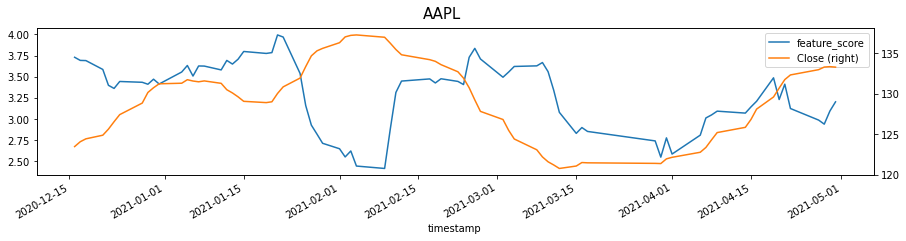

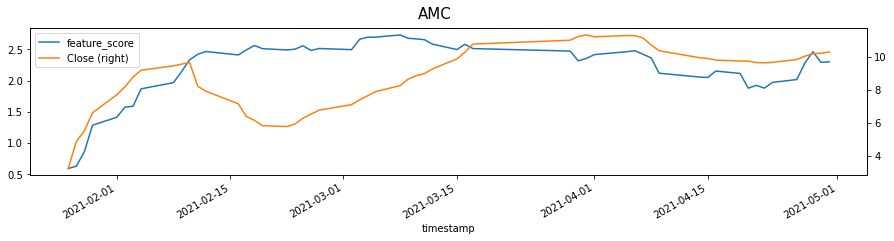

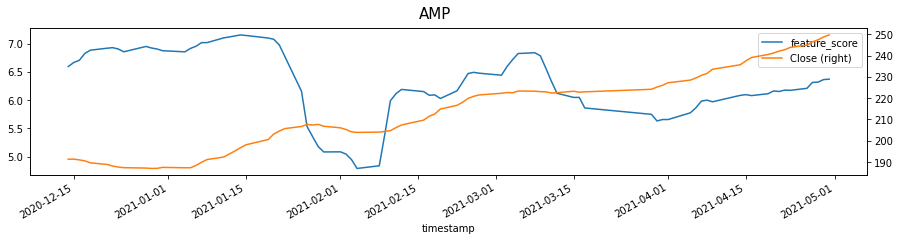

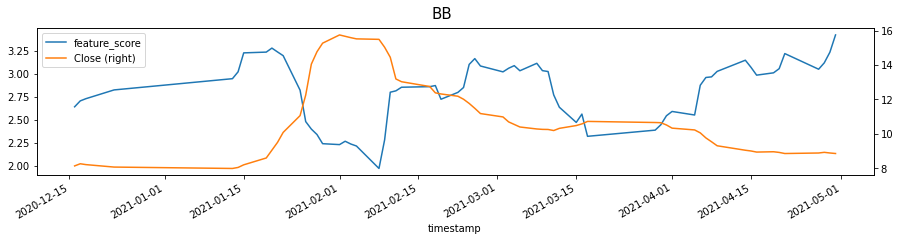

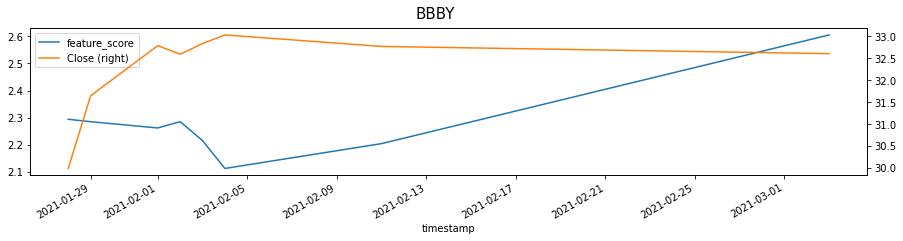

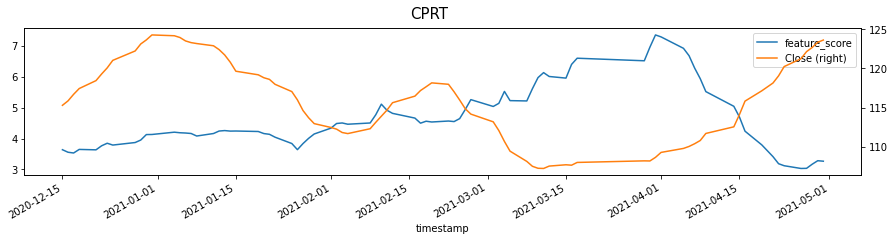

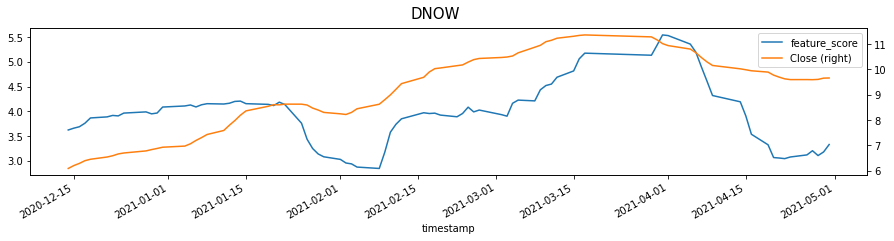

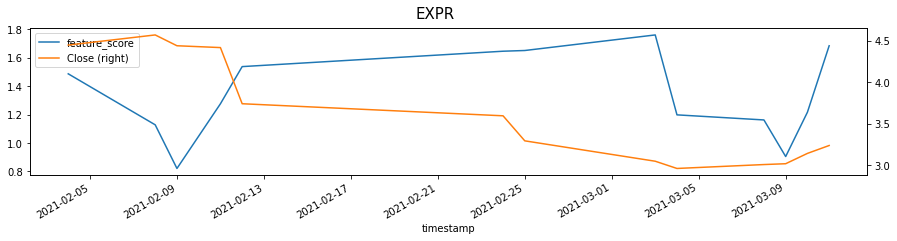

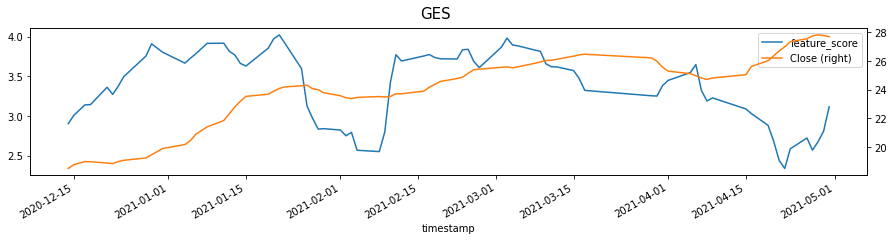

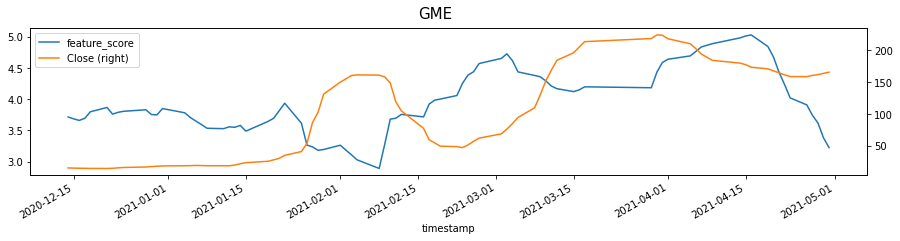

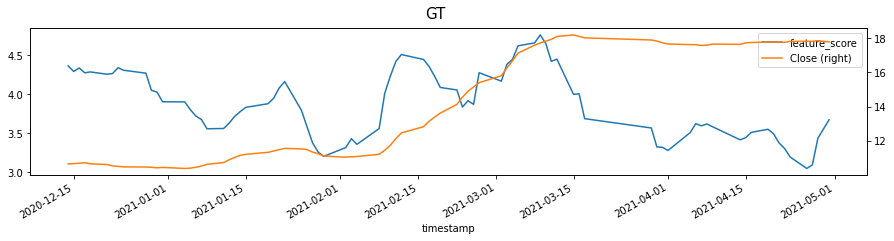

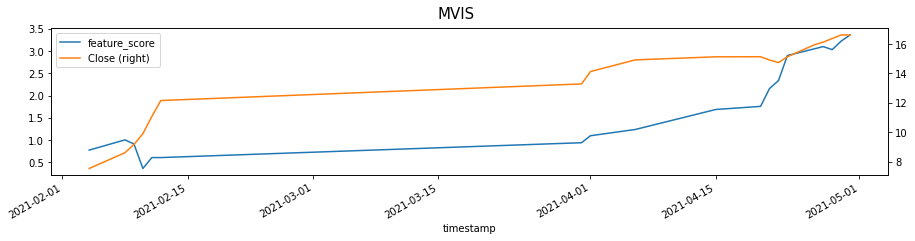

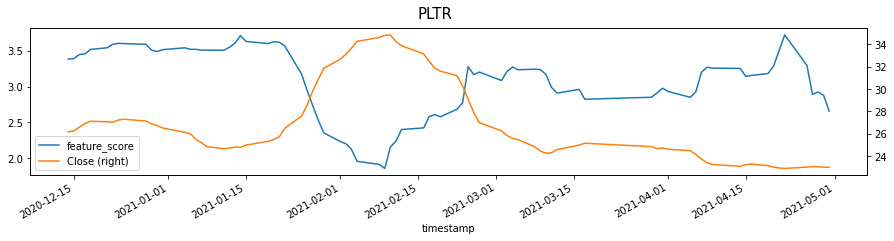

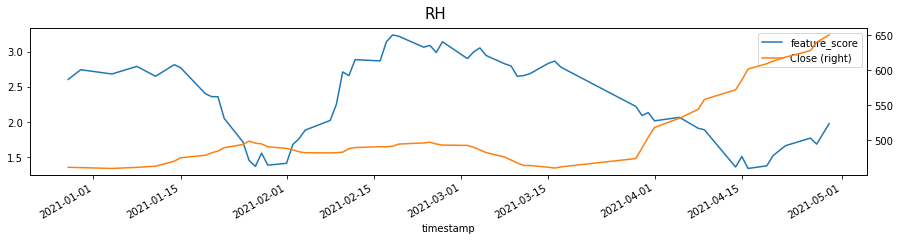

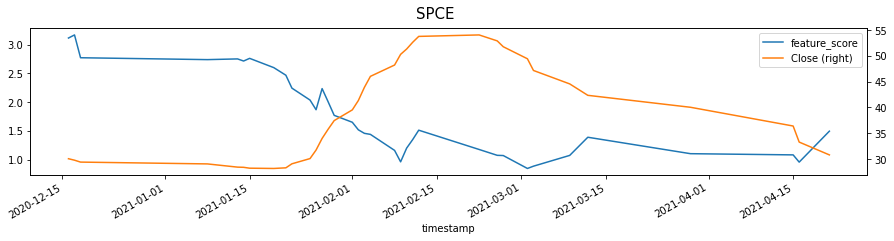

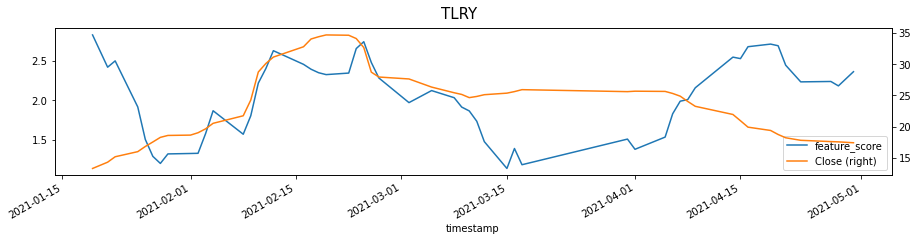

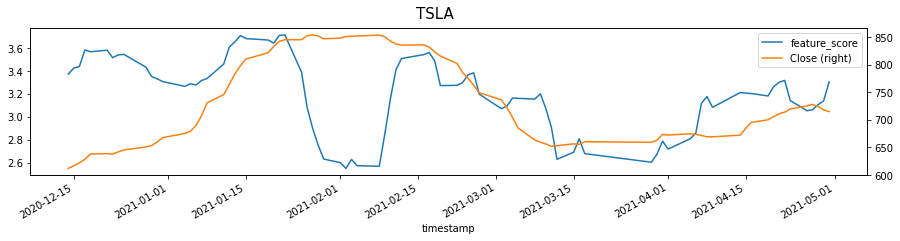

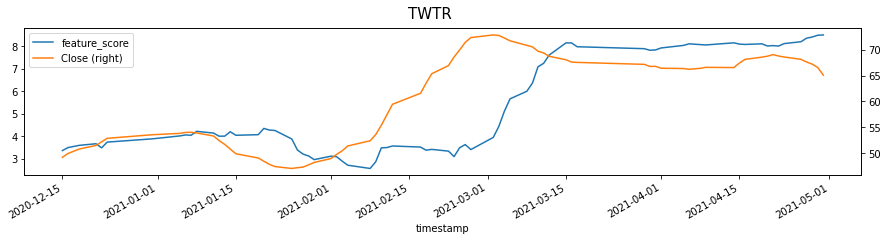

In [ ]:
# feature_columns = ['sentiment_median','sentiment_mean', 'comments_per_post_median', 'comments_per_post_mean']
feature_columns = ['feature_score']
change_columns = [*feature_columns, 'Close']

for symbol in symbols:
    fig, axis = plt.subplots(1,len(feature_columns))
    fig.suptitle(symbol.upper(), size=15)

    for i,feature in enumerate(feature_columns):
        df_timeseries_plotted = df_score_prices_joined[symbol].copy(deep=True)
        df_timeseries_plotted\
            .set_index('timestamp')\
            [[feature, 'Close']]\
            .rolling(10).mean()\
            .plot(
                secondary_y='Close',
                # title=feature.replace('_', ' ').replace(' per post', '/Post').title(),
                ax=axis if len(feature_columns) == 1 else axis[i],
                figsize=(15, 3)
            )
        
    plt.show()


## 10. Day-to-Day Changes

Analyzing the day-to-day changes allows to quickly recognize potential changes in overall momentum in the forum, which can lead to future movements in the stock price. 
### 10.1. Calculate Day-to-Day Changes

Day-to-day changes are calculated for both the feature score_change as well as the stock closing price.

In [ ]:
df_changes = dict()
for symbol in symbols:

    df_changes[symbol] = df_score_prices_joined[symbol].copy(deep=True)
    for change_column in change_columns:
        df_changes[symbol][change_column + '_change'] = df_changes[symbol][change_column].pct_change()

    df_changes[symbol] = df_changes[symbol].drop(columns=change_columns)
    
df_changes['gme']

,timestamp,feature_score_change,Close_change
0,2020-12-01,NaN,NaN
1,2020-12-02,-0.024583,0.049367
2,2020-12-03,-0.025076,-0.027744
3,2020-12-04,0.120620,0.048387
4,2020-12-07,-0.097077,-0.032544
...,...,...,...
88,2021-04-26,0.316892,0.117410
89,2021-04-27,-0.179026,0.052329
90,2021-04-28,0.282307,0.004556
91,2021-04-29,-0.346477,-0.013383


### 10.2. Visualize Day-to-Day Changes per Stock

The following charts offer a visual overview of how the Feature Score day-to-day changes of a stock and its day-to-day stock price changes transition over time.

Note that the shown values are rolling averages in order to facilitate the detection of trends.

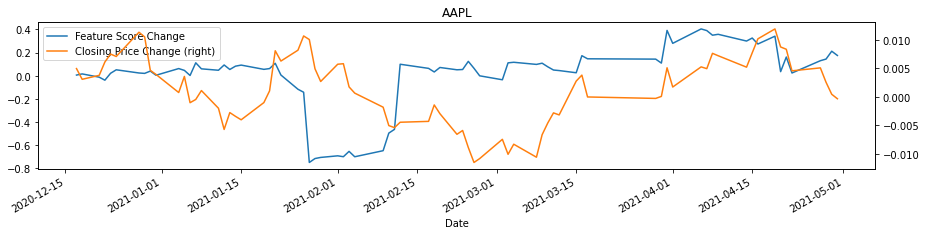

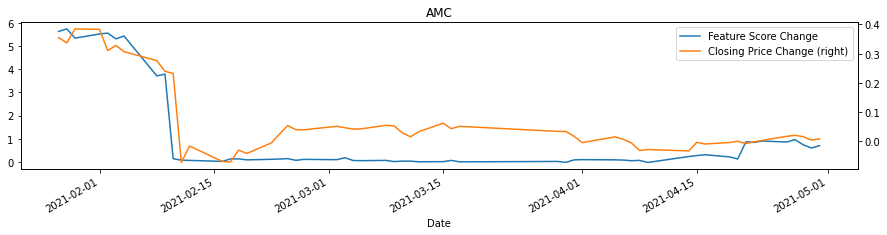

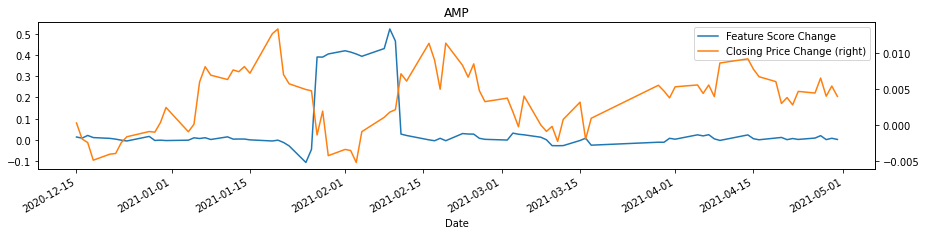

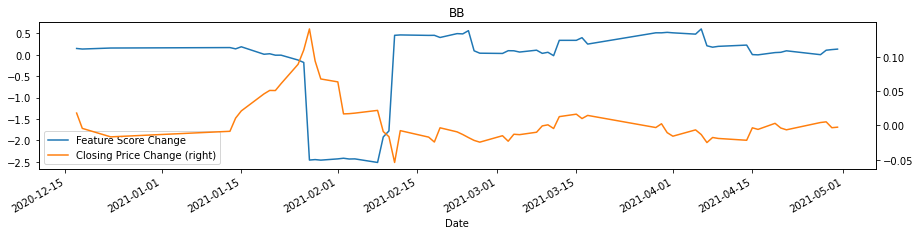

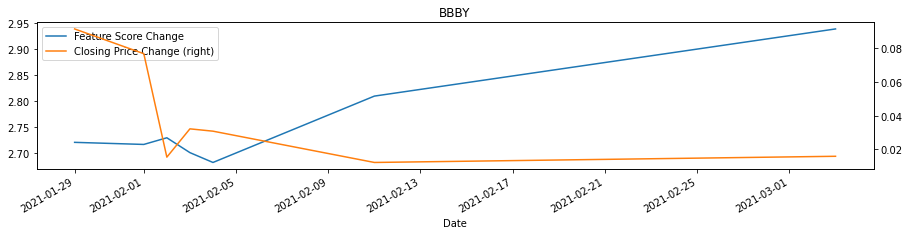

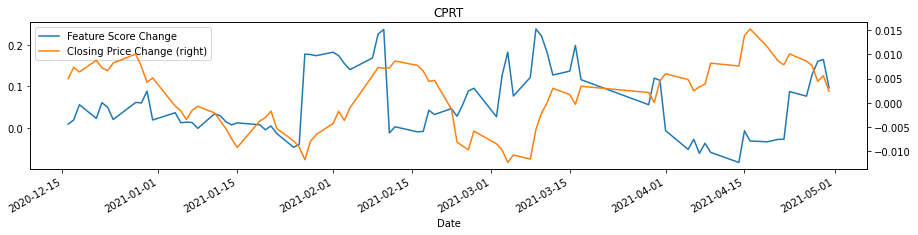

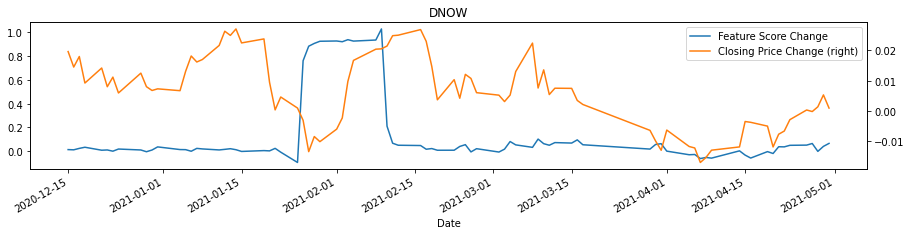

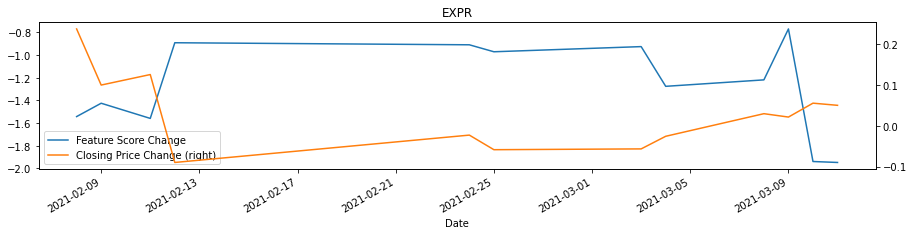

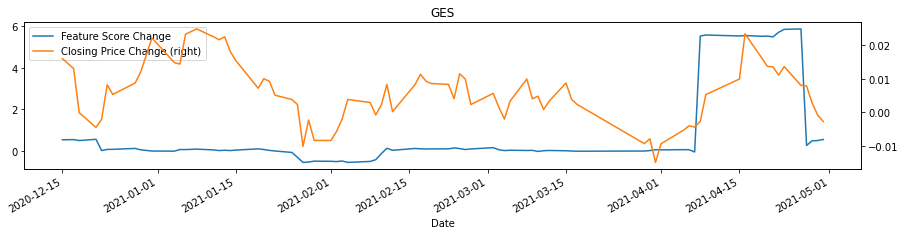

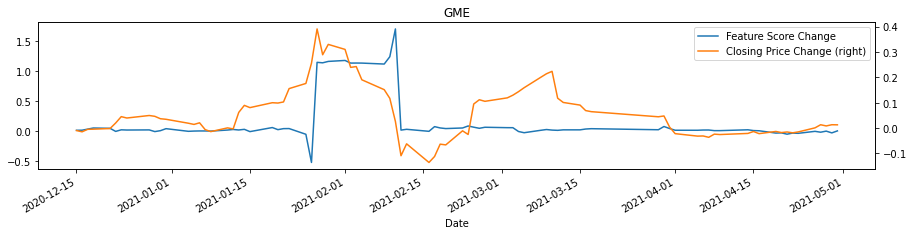

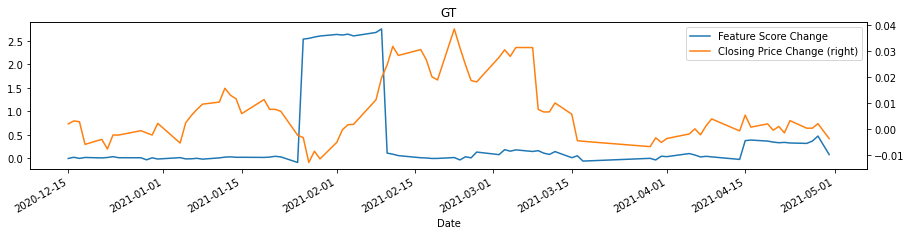

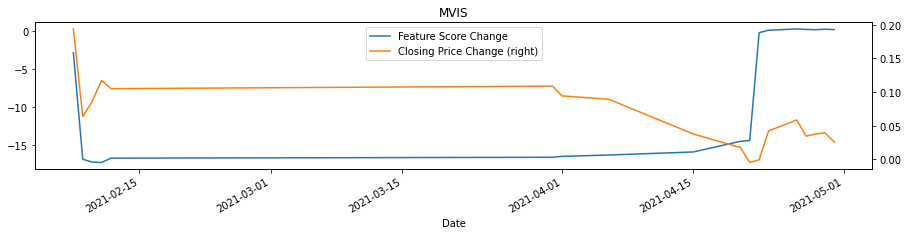

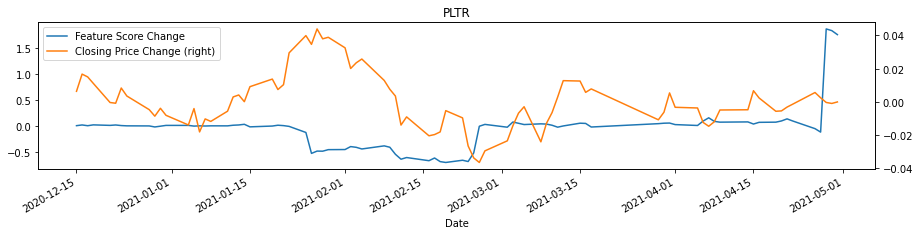

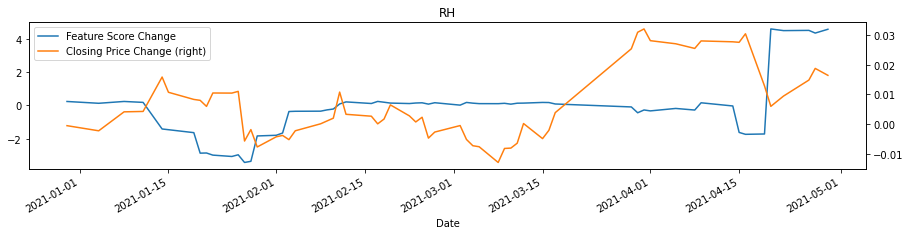

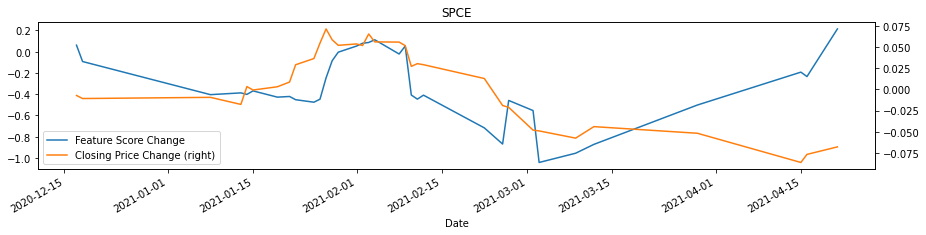

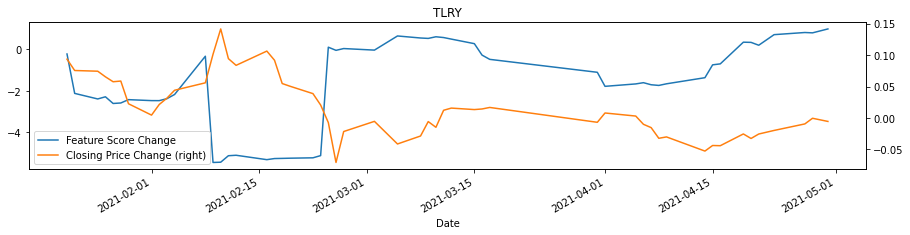

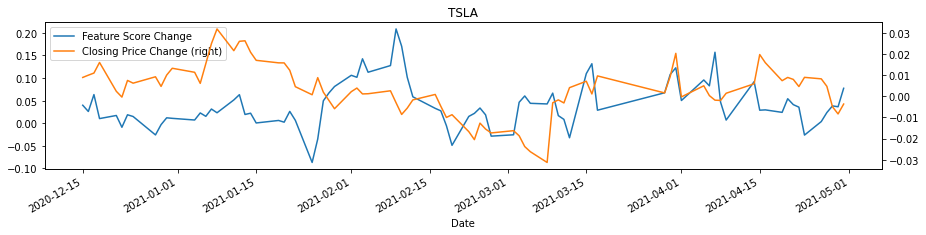

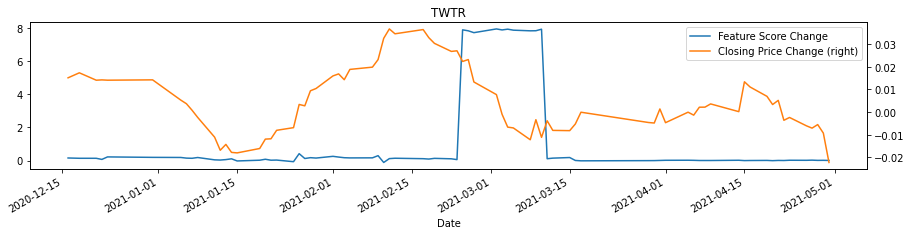

In [ ]:
for symbol in symbols:
    df_single_symbol = df_changes[symbol].copy(deep=True)
    df_single_symbol\
        .rename(columns={
            'timestamp': 'Date',
            'feature_score_change': 'Feature Score Change',
            'Close_change': 'Closing Price Change', 
        })\
        .set_index('Date')\
        .rolling(10).mean()\
        .plot(
            secondary_y='Closing Price Change',
            title=symbol.upper(),
            figsize=(15, 3),
        )

## 11. Correlations
In this section we decided to analyse the correlations between the percent change in stock price and the percent change of the feature score for each stock. If we would have been able to find a meaningful correlation, basing a trading strategy on this would have been very promising. However, unfortunately we weren't able to find one. 

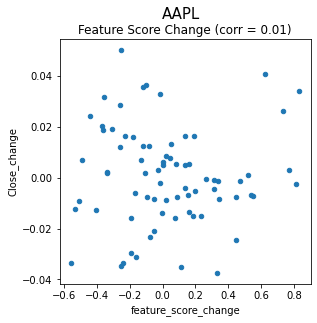

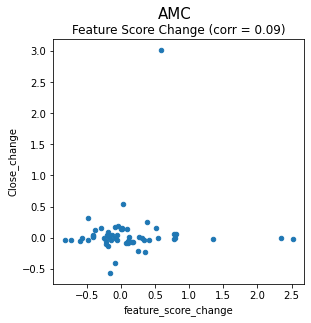

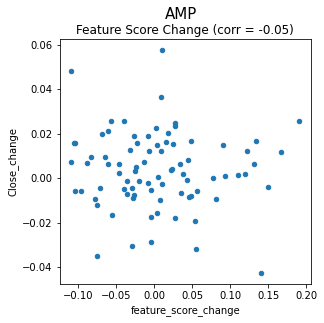

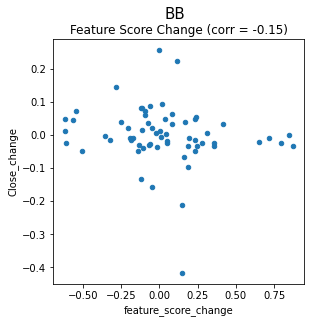

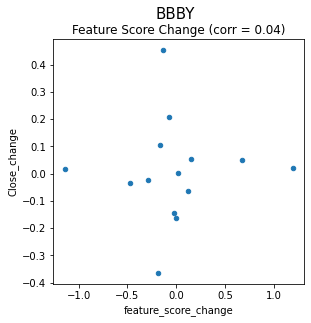

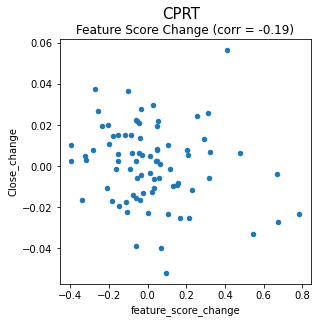

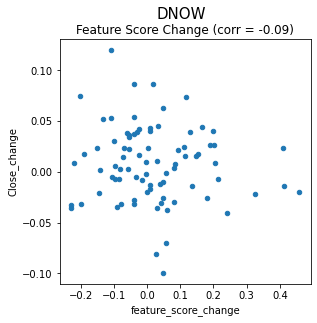

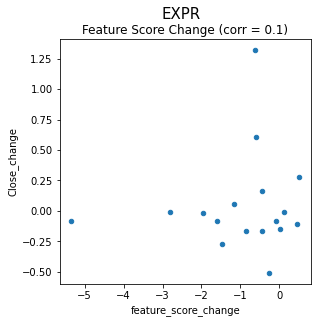

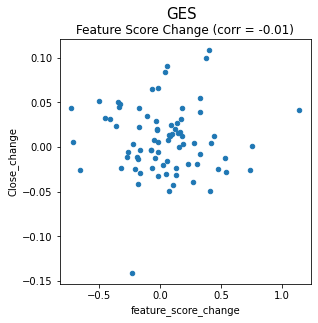

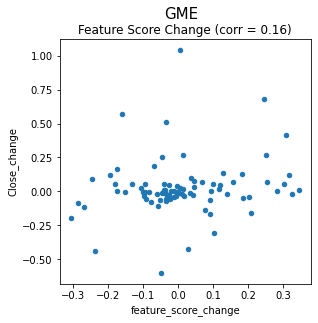

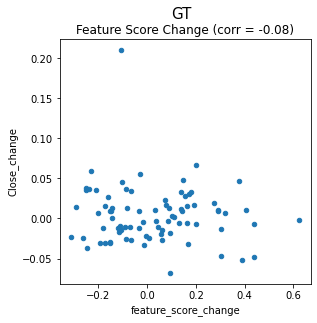

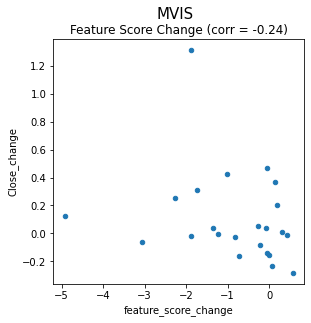

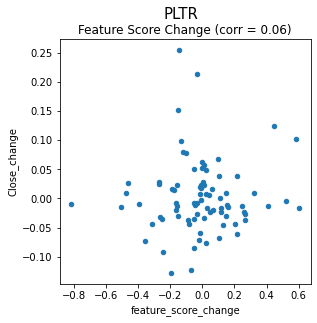

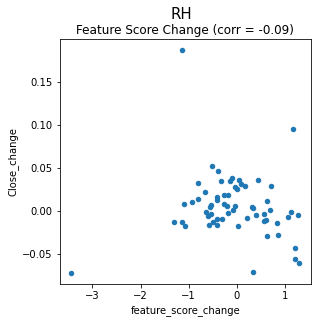

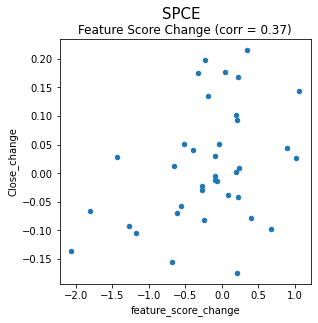

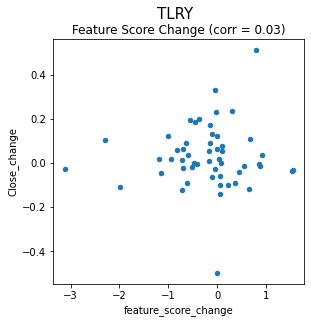

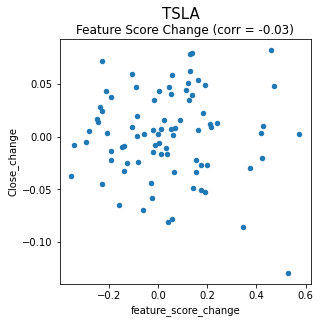

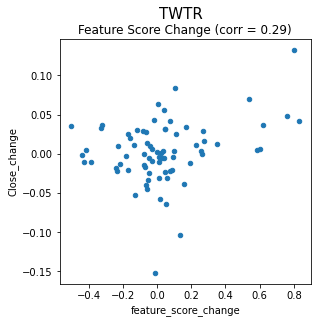

In [ ]:
# filter outliers:
def filter_outliers(df, column, quantile=0.05):
    return df[(df[column] < df[column].quantile(1-quantile)) & (df[column] > df[column].quantile(quantile))].reset_index(drop=True)

feature_changes_columns = list(map(lambda feature: feature+'_change', feature_columns))

for symbol in symbols:
    fig, axes = plt.subplots(1,len(feature_changes_columns))
    fig.suptitle(symbol.upper(), size=15)

    for i,feature in enumerate(feature_changes_columns):
        df_correlations_plotted = df_changes[symbol].copy(deep=True)
        df_correlations_plotted = filter_outliers(df_correlations_plotted, feature)
        correlation = df_correlations_plotted.corr()[feature]['Close_change']
        df_correlations_plotted\
            .plot.scatter(
                x=feature,
                y='Close_change',
                title=feature.replace('_', ' ').replace(' per post', '/Post').title() + ' (corr = ' + str(round(correlation, 2)) + ')',
                ax=axes if len(feature_changes_columns) == 1 else axes[i],
                figsize=(4.5, 4.5)
            )
        
    plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d7886875-5320-40a2-af00-cc1d95e2b7d3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>